# Topic diversity exploration

In [4]:
%pip install datasets pandas scikit-learn umap-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch

def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = choose_device()

/home/ritsuko/ai/nlp/instruct-hn/.conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [26]:
if device == "cuda":
    %pip install cudf-cu12 cuml-cu12 cugraph-cu12 cucim --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 MB 3.4 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.8/961.8 MB 2.4 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.5 MB/s eta 0:00:00:00:0100:03
  Obtaining dependency information for cucim from https://files.pythonhosted.org/packages/80/3b/b2f8c0967ab9916336e0a53a0b099163232296fb8a3387c84469ffbc88be/cucim-23.8.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 4.2 MB/s eta 0:00:00
  Obtaining dependency information for cuda-python<13.0a0,>=12.0 from https://files.pythonhosted.org/packages/2b/5c/ad3b6bee78f95134834dc2ce8805fc12ac70d7a9ba065e2d7c05263549dc/cuda_python-12.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cupy-cuda12x>=12.0.0 from https://files.py

## K-means clustering

In [2]:
import pandas as pd
import numpy as np
import datasets

dataset = datasets.load_from_disk("./datasets/post-title-bge-cls_pooled")
df = dataset.to_pandas()

/home/ritsuko/ai/nlp/instruct-hn/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We train clusters on a sample set of 25k titles:

In [10]:
np.random.seed(42)

df_train_sample = df.sample(n=25_000, random_state=42)

In [11]:
train_emb_array = np.array(list(df_train_sample["embeddings"]))

BERT-style dense 768-dimensional embeddings are a bit unwieldy. Dimensionality reduction to ~32 dimensions empirically seems fine.

In [31]:
def create_reducer(device, n_components=2):
    if device == "TEST":
        from cuml import UMAP
        reducer = UMAP(n_components=n_components, n_neighbors=25, min_dist=0.1, n_jobs=-1, metric="manhattan", random_state=42)
    else:
        import umap
        reducer = umap.UMAP(n_components=n_components, n_neighbors=10, min_dist=0.075, metric="euclidean", n_jobs=-1)

    return reducer

In [59]:

# Not using cuML because the implementation is completely fucked
# Reduce dimensionality of train_emb_array using UMAP to 3 dimensions
reducer = create_reducer(device, n_components=32)
train_emb_reduced = reducer.fit_transform(train_emb_array)

In [28]:
# Abstract out the clustering creation so we can switch between CPU and GPU
def create_clusterer(device, n_clusters=20):
    if device == "cuda":
        from cuml.cluster import KMeans
        clusterer = KMeans(n_clusters=n_clusters, init="scalable-k-means++", n_init=20)
    else:
        from sklearn.cluster import MiniBatchKMeans
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", n_init=20)
    
    return clusterer

In [53]:
silhouette_avgs = {}
db_scores = {}

# Powers of 2 of k values to try
k_values = [2**i for i in range(1, 10)]

from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

for n_clusters in k_values:
    # Initialize MiniBatchKMeans
    kmeans = create_clusterer(device, n_clusters=n_clusters)
    
    # Fit the model
    kmeans = kmeans.fit(train_emb_reduced)
    
    # Get cluster labels
    labels_sample = kmeans.labels_
    
    # Compute Davies-Bouldin score
    db_score = davies_bouldin_score(train_emb_reduced, labels_sample)

    """
    print("Silhouette scores per cluster:")
    for label, score in silhouette_dict.items():
     # Get score for each sample
    silhouette_vals = silhouette_samples(train_emb_reduced, labels_sample, metric='cosine')

    # Save silhouette score for each cluster
    silhouette_dict = {}
    for label in np.unique(labels_sample):
        label_silhouette_vals = silhouette_vals[labels_sample == label]
        silhouette_dict[label] = label_silhouette_vals.mean()

       print(f"Cluster {label}: {score}")
    """
    # Compute silhouette score
    silhouette_avg = silhouette_score(train_emb_reduced, labels_sample, metric='cosine', n_jobs=-1)

    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    print(f"The average Davies-Bouldin score is: {db_score }")
    
    # Store silhouette_avg in dictionary
    silhouette_avgs[n_clusters] = silhouette_avg
    db_scores[n_clusters] = db_score
    

For n_clusters = 2, the average silhouette_score is : 0.48659202456474304
The average Davies-Bouldin score is: 1.2533403737692463
For n_clusters = 4, the average silhouette_score is : 0.438591867685318
The average Davies-Bouldin score is: 1.3471810607049335
For n_clusters = 8, the average silhouette_score is : 0.40017178654670715
The average Davies-Bouldin score is: 1.2934781722842486
For n_clusters = 16, the average silhouette_score is : 0.3806622326374054
The average Davies-Bouldin score is: 1.2993677838530675
For n_clusters = 32, the average silhouette_score is : 0.41944563388824463
The average Davies-Bouldin score is: 1.2013005066108196
For n_clusters = 64, the average silhouette_score is : 0.4133729338645935
The average Davies-Bouldin score is: 1.1857248762059733
For n_clusters = 128, the average silhouette_score is : 0.4420092701911926
The average Davies-Bouldin score is: 1.1457137855119177
For n_clusters = 256, the average silhouette_score is : 0.43892553448677063
The average Da

## Hierarchical clustering

However, this doesn't tell the whole story. Let's get a reference clustering at 256 clusters and get the hierarchy out.

In [7]:
%pip install matplotlib

  Obtaining dependency information for pillow>=6.2.0 from https://files.pythonhosted.org/packages/7a/07/e896b096a77375e78e02ce222ae4fd6014928cd76c691d312060a1645dfa/Pillow-10.0.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
Using cached Pillow-10.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rembg 2.0.25 requires click==8.1.3, which is not installed.
rembg 2.0.25 requires fastapi==0.80.0, which is not installed.
diffusers 0.8.0.dev0 requires Pillow<10.0, but you have pillow 10.0.1 which is incompatible.
rembg 2.0.25 requires numpy==1.21.6, but you have numpy 1.25.2 which is incompatible.
rembg 2.0.25 requires pillow==9.2.0, but you have pillow 10.0.1 which is incompatible.
rembg 2.0.25 requires scipy==1.7.3, but you have scipy 1.11.2 which is incompatible.
rembg 2.0.25 requires tqdm==4.64.0, but you have tq

In [61]:
kmeans_train = create_clusterer(device, n_clusters=256)
kmeans_train.fit_predict(train_emb_reduced)

array([150, 214,  29, ..., 167, 184,  39], dtype=int32)

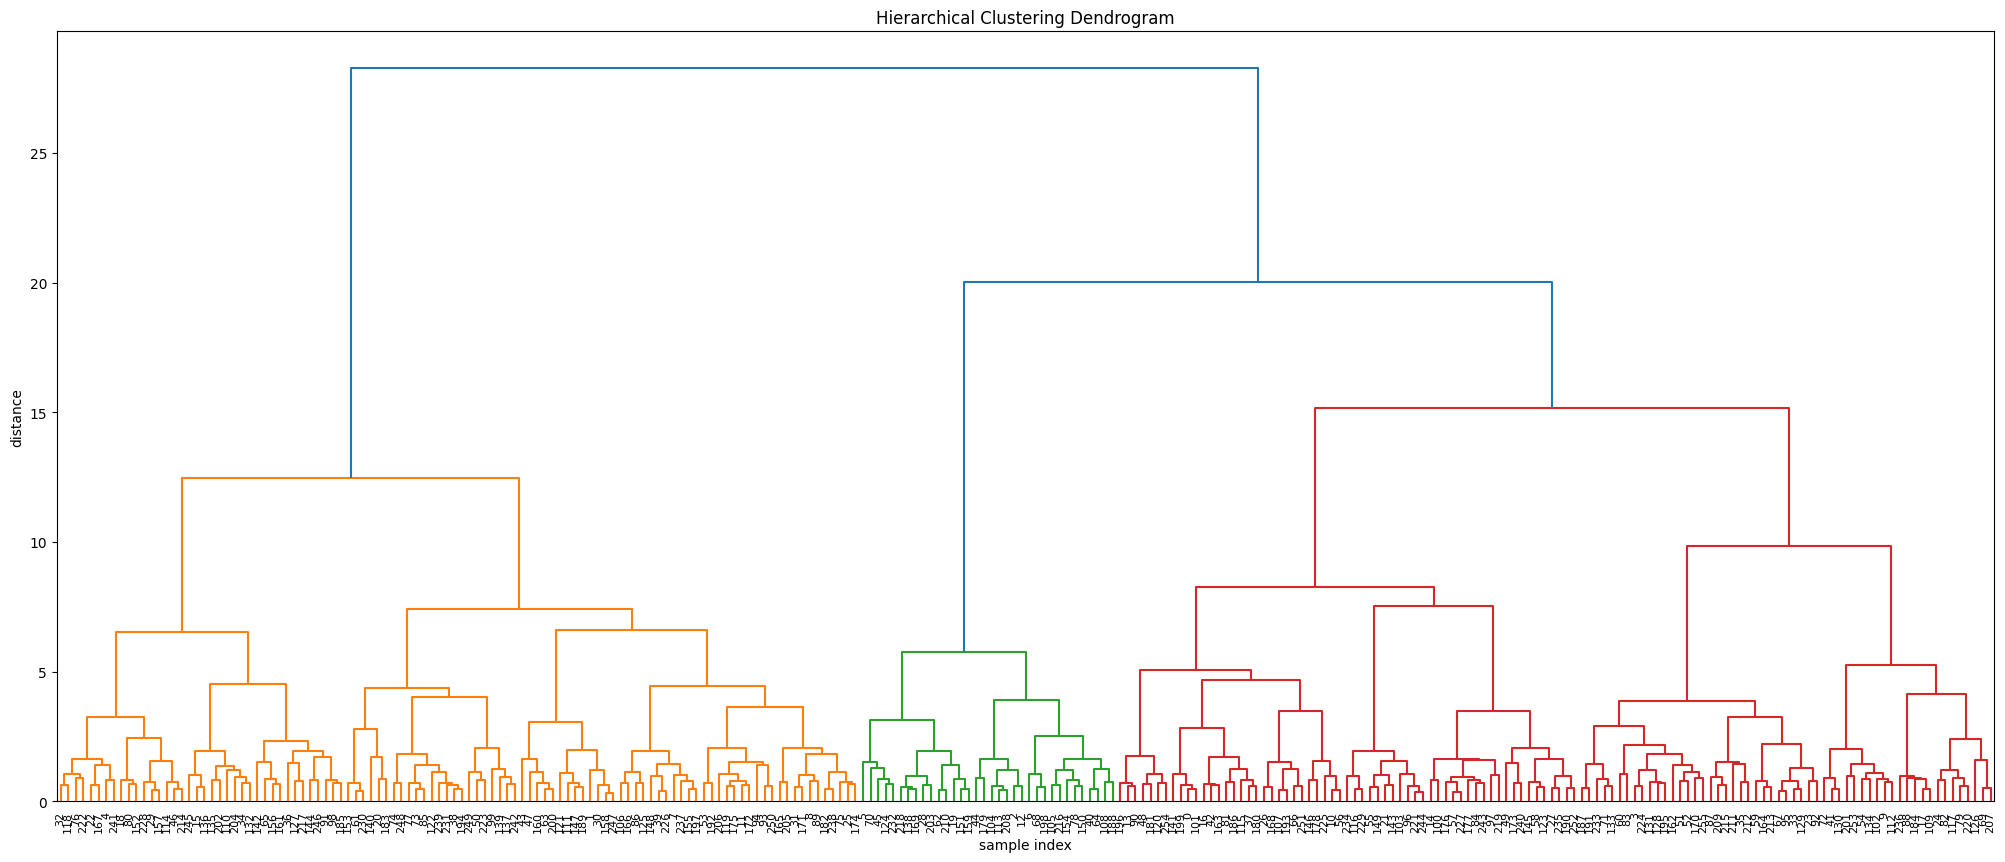

In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix from kmeans centroids
Z = linkage(kmeans_train.cluster_centers_, method="ward")

# Plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.,)
plt.show()

In [63]:
def get_clusters_at_depth(Z, depth, current_index=0, current_depth=0):
    if current_depth == depth:
        return [current_index]
    
    left_child, right_child = Z[current_index][:2].astype(int)
    
    if left_child < len(Z) + 1:
        left_clusters = [left_child]
    else:
        left_clusters = get_clusters_at_depth(Z, depth, left_child - len(Z) - 1, current_depth + 1)
    
    if right_child < len(Z) + 1:
        right_clusters = [right_child]
    else:
        right_clusters = get_clusters_at_depth(Z, depth, right_child - len(Z) - 1, current_depth + 1)
    
    return left_clusters + right_clusters


In [69]:
def get_centroids(Z, depth):
    clusters = get_clusters_at_depth(Z, depth)
    centroids = Z[clusters]
    return centroids

In [80]:
Z.shape

(255, 4)

In [72]:
from sklearn.cluster import KMeans
kmeans_depth_2 = KMeans(n_clusters=4, init=get_centroids(Z, 4))

In [73]:
df_train_sample["cluster_lvl_2"] = kmeans_depth_2.fit_predict(train_emb_reduced)

/home/ritsuko/ai/nlp/instruct-hn/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ritsuko/ai/nlp/instruct-hn/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: The shape of the initial centers (2, 4) does not match the number of clusters 4.

## Applying the clusters

In [54]:
n_clusters=256

In [55]:
kmeans = create_clusterer(device, n_clusters=n_clusters)

kmeans = kmeans.fit(train_emb_reduced)

Optional: Remove duplicate columns. Idempotent if not

In [10]:
# Remove duplicates
# Drop columns ending with '_y'
columns_to_drop = [col for col in df.columns if col.endswith('_y')]
df.drop(columns=columns_to_drop, inplace=True)

# Rename columns ending with '_x' to remove the suffix
columns_to_rename = {col: col.rstrip('_x') for col in df.columns if col.endswith('_x')}
df.rename(columns=columns_to_rename, inplace=True)


In [56]:
import numpy as np

embeddings_matrix = reducer.transform(np.stack(df["embeddings"].to_numpy()).astype(np.float32))

In [57]:
df["title_cluster"] = kmeans.predict(embeddings_matrix)
df["title_cluster"].value_counts()

97     5694
50     5301
26     4343
108    4309
175    4307
       ... 
222     381
120     328
205     289
153     278
135     103
Name: title_cluster, Length: 256, dtype: int64

In [58]:
# Function to print 5 representative titles for each cluster
def print_representative_titles(df, cluster_col='title_cluster', title_col='title'):
    unique_clusters = df[cluster_col].unique()
    
    for cluster in unique_clusters:
        representative_titles = df[df[cluster_col] == cluster][title_col].sample(7, replace=True).tolist()
        print(f"Cluster {cluster} Representative Titles:")
        for title in representative_titles:
            print(f"  - {title}")

print_representative_titles(df)

Cluster 167 Representative Titles:
  - Adobe CTO on Flash for Mac
  - Adobe Updates Flash Builder and Flex to Support Building iOS Applications
  - Toward a more useful keyboard
  - LinkedIn Intro: Doing the Impossible on iOS
  - ZSA Moonlander: A next-generation ergonomic keyboard
  - Anatomy of a Native Feeling HTML5 iOS App
  - Ask HN: How do Mac software developers make realistic icons?
Cluster 186 Representative Titles:
  - Ask HN: I'm a New Manager – How to Best Handle Employee Grievance?
  - Ask HN: How can I get a tech job that's more social?
  - Ask HN: Interview tomorrow – How to learn whether an org is “healthy”?
  - Reverse job fair Jan 16th: Job seekers have tables, recruiters walk around.
  - Ask HN: What Are You Working On? (March 2023)
  - Ask HN: How to make a career working remotely?
  - Ask HN: Those who left software development for a different technical field?
Cluster 155 Representative Titles:
  - Building a Bejeweled Bot
  - Show HN: See what Apps your friends ar

## Topic modeling

Can we make these clusters more legible? Copy-pasting from Maarten Grootendorst's [c-TF-IDF](https://www.maartengrootendorst.com/blog/ctfidf/) (though not the whole BERTopic skeleton yet):

In [26]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """
        n_samples: Number of unjoined documents.

        Learn the idf vector (global term weights) 
        """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

Let's apply this to the whole fucking set:

In [27]:
# Concat all docs per class in train set
docs_per_class_train = df.groupby('title_cluster', as_index=False).agg({'title': ' '.join})

# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class_train.title)
count = count_vectorizer.transform(docs_per_class_train.title)
words = count_vectorizer.get_feature_names_out()

# Create c-tfidf vectorizer
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs_per_class_train))

OK, let's see some of the results:

In [28]:
ctfidf_arr = ctfidf.toarray()
words_per_cluster = [[words[index] for index in ctfidf_arr[cluster].argsort()[-10:]] for cluster in range(n_clusters)]

In [29]:
cluster_counts = df["title_cluster"].value_counts()
cluster_counts.sort_index(inplace=True)
cluster_df = pd.DataFrame({"cluster": cluster_counts.index, "count": cluster_counts.values, "top_words": [", ".join(x) for x in words_per_cluster]})
cluster_df.sort_values("count", ascending=False, inplace=True)
cluster_df.head(20)

,cluster,count,top_words
265,265,3486,"shakespeare, poetry, eliot, samuel, tolkien, p..."
9,9,3375,"teslas, ford, motors, ion, batteries, toyota, ..."
5,5,3218,"f8, metaverse, snapchat, delete, advertisers, ..."
209,209,3180,"mpaa, torrents, hbo, hulu, piracy, drm, dmca, ..."
26,26,3107,"skylake, processors, radeon, i9, threadripper,..."
197,197,3090,"spyware, foia, fisa, prism, patriot, revelatio..."
35,35,2994,"nixos, rhel, fedora, lts, arch, 04, centos, di..."
333,333,2913,"bootstrapping, founding, cofounders, solo, ent..."
422,422,2825,"rusty, rustc, rustconf, crate, async, crates, ..."
500,500,2663,"whistleblower, fb, gawker, influencers, teens,..."


In [177]:
cluster_df.to_csv("datasets/title-cluster-top-words.csv", index=False)

In [171]:
df["title_cluster"].value_counts()

title_cluster
55     4517
323    3758
326    2872
151    2856
163    2773
       ... 
411     141
188     137
249     136
290     117
179      76
Name: count, Length: 512, dtype: int64

In [65]:
df_silhouette_sample = df.sample(n=10_000, random_state=64)

X_sample = np.stack(df_silhouette_sample['embeddings'].values)
labels_sample = df_silhouette_sample['title_cluster'].values

Wow, this is useless.

In [22]:
import pickle
pkl_fname = "title-kmeans.pkl"
with open(pkl_fname, 'wb') as file:
    pickle.dump(kmeans, file)

In [ ]:
"""
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
"""

## Sheer utter boredom

let's predict the HN post score in the dumbest way possible.

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [72]:
bins = [0, 32, 64, 128, 256, 512, 1024, 2048, float('inf')]
labels = ['0-32', '32-64', '64-128', '128-256', '256-512', '512-1024', '1024-2048', '2048+']

df['score_range'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)
df['score_label'] = df['score_range'].astype('category').cat.codes


In [73]:
df["score_label"].value_counts()

score_label
1    126513
2    112603
0     86444
3     79324
4     34975
5      9261
6      1455
7       158
Name: count, dtype: int64

In [128]:
# Separate the data by 'score_label'
grouped = df.groupby('score_label')

# Determine the number of samples to draw from each group to balance them
# Here, we aim to match the 80% size of the smallest group (bucket 7)
target_size = int(0.8 * grouped.size().min())

# Sample from each group
sampled_dfs = [group.sample(target_size, replace=True) for _, group in grouped]

# Combine the sampled data to create a balanced training set
balanced_df = pd.concat(sampled_dfs, ignore_index=True)


embeddings = np.array(balanced_df["embeddings"].tolist())
labels = balanced_df["score_label"].values

In [141]:
import torch

X = torch.tensor(embeddings, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

In [142]:
from torch.utils.data import DataLoader, TensorDataset
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [132]:
import torch.nn as nn

# Define the model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.fc(x)

In [150]:
import torch.optim as optim
# Initialize the model, loss, and optimizer
model = SimpleClassifier(X_train.shape[1], len(bins) - 1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [143]:
y_train.shape

torch.Size([806])

In [151]:
# Training loop
for epoch in range(10):  # 10 epochs as an example
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch}, Loss: {loss.item()}")



Epoch 0, Loss: 2.093410015106201
Epoch 1, Loss: 1.9829645156860352
Epoch 2, Loss: 2.014063835144043
Epoch 3, Loss: 1.9200794696807861
Epoch 4, Loss: 1.9282312393188477
Epoch 5, Loss: 1.9511048793792725
Epoch 6, Loss: 2.049727439880371
Epoch 7, Loss: 1.81847083568573
Epoch 8, Loss: 2.116856336593628
Epoch 9, Loss: 1.804591178894043


In [91]:
len(bins)

9

In [152]:
# DataLoader for test set
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model
correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        # Forward pass
        outputs = model(batch_X)
        
        # Get the index of the highest score in the output tensor
        _, predicted = torch.max(outputs.data, 1)
        
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 16.83%


In [153]:
# Assuming 'model' is your trained PyTorch model and 'df' is your DataFrame

# Convert embeddings to PyTorch tensor
embeddings = torch.tensor(df['embeddings'].tolist(), dtype=torch.float32)

# DataLoader
data_loader = DataLoader(embeddings, batch_size=2048, shuffle=False)

# Store predictions
predictions = []

# Evaluate
with torch.no_grad():
    for batch_X in data_loader:
        # Forward pass
        outputs = model(batch_X)
        
        # Get the index of the highest score in the output tensor
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.tolist())

# Add predictions to DataFrame
df['predicted_label'] = predictions


In [154]:
# Create a new boolean column that is True if the predicted and actual labels match, otherwise False
df['is_correct'] = df['score_label'] == df['predicted_label']

# Group by the cluster ID and calculate both the mean and count of 'is_correct' for each group
cluster_stats = df.groupby('title_cluster')['is_correct'].agg(['mean', 'count'])

# Rename columns for better understanding
cluster_stats.columns = ['mean_accuracy', 'count']

# Sort the DataFrame if needed
cluster_stats = cluster_stats.sort_values(by=['count', 'mean_accuracy'], ascending=[False, False])

In [118]:
cluster_stats.to_csv("datasets/cluster_stats_128")

In [155]:
# Group by the actual score label bins and calculate the mean accuracy for each group
score_bin_stats = df.groupby('score_label')['is_correct'].agg(['mean', 'count'])

# Sort the DataFrame based on mean accuracy or count as you prefer
score_bin_stats = score_bin_stats.sort_values(by=['mean', 'count'], ascending=[False, False])

# Rename columns for better understanding
score_bin_stats.columns = ['mean_accuracy', 'count']
score_bin_stats

,mean_accuracy,count
score_label,,
6,0.426117,1455
7,0.316456,158
1,0.239912,126513
0,0.148350,86444
3,0.132595,79324
5,0.092107,9261
4,0.083145,34975
2,0.079634,112603
